gofasta vs amanual mutation calling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
import numpy as np
import os

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option("display.max_columns", None)

In [19]:
sc2_mm_dir = "/home/yutianc/bjorn_rep/output/SC2/escape_all"
hu1_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_Hu1/'
ba1_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_BA.1_escape/'
ba2_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_BA.2_escape/'


pb2_old_dir = '/home/yutianc/bjorn_rep/data/PB2-DMS/'
pb2_gf_dir = '/home/yutianc/bjorn_rep/output/PB2/gf_PP/'
pb2_mm_dir = '/home/yutianc/bjorn_rep/output/PB2/mm/'
cy_gf_dir = '/home/yutianc/bjorn_rep/output/PB2/gf_CY/'
cy_mm_dir = '/home/yutianc/bjorn_rep/output/PB2/mm/'

sc2_escape_dir = '/home/yutianc/bjorn_rep/output/SC2/escape_all/'
ba275_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_BA.2.75/'
ba45_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_BA.4_BA.5/'
xbb_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_XBB.1.5/'
jn1_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_JN.1/'
kp2_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_KP.2/'
kp3_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_KP.3/'


In [4]:
ambiguous_nuc = ['R', 'Y', 'W', 'S', 'K', 'M', 'B', 'D', 'H', 'V', 'N']

In [5]:
def process(path, common_set):
    df = pd.read_csv(path, sep="\t")
    if common_set:
        df_filtered = df.copy()
        df_filtered["sra"] = df_filtered["sra"].apply(lambda x: x.split('/')[2] if len(x.split('/')) == 4 else x)
        df_filtered = df_filtered.loc[(df_filtered["sra"].isin(common_set)), :]

        return df, df_filtered
    else:
        return df, None

In [6]:
def corr_plt_nuc(standard, manual, title):
    standard_grp = (
        standard[~standard["alt"].str.upper().isin(ambiguous_nuc)]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_standard")
    )

    manual_grp = (
        manual[~manual["alt"].str.upper().isin(ambiguous_nuc)]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_manual")
    )
    
    merged2 = pd.merge(standard_grp, manual_grp, on='sra', how="outer").fillna(0)

    plt.scatter(merged2['pos_count_manual'], merged2['pos_count_standard'], color='lightblue')
    minv = min(merged2['pos_count_manual'])
    maxv = max(merged2['pos_count_manual'])
    
    plt.plot([minv, maxv], [minv, maxv], 'r--', label='y = x')
    plt.legend(loc='upper right')
    plt.xlabel("pos count - our mutation calling")
    plt.ylabel("pos count - standard")
    plt.title(f"Nuc Comparision - {title}")
    plt.tight_layout()
    plt.show()

    pos_mismatch = merged2[merged2['pos_count_standard'] != merged2['pos_count_manual']]
    pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
    pos_mismatch = pos_mismatch.sort_values(by=["gap"], ascending=False)

    return pos_mismatch

In [7]:
def corr_plt_aa(standard, manual, title):
    standard_grp = (
        standard[(~standard["alt"].str.upper().isin(ambiguous_nuc)) & ((~standard["GFF_FEATURE"].isna()))]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_standard")
    )

    manual.loc[(manual["ref_aa"] == "X") | (manual["alt_aa"] == "X"), ["GFF_FEATURE", "ref_aa", "alt_aa", "pos_aa"]] = np.nan
    manual_grp = (
        manual[(~manual["alt"].str.upper().isin(ambiguous_nuc)) & ((~manual["GFF_FEATURE"].isna()))]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_manual")
    )
    
    merged2 = pd.merge(standard_grp, manual_grp, on='sra', how="outer").fillna(0)

    plt.scatter(merged2['pos_count_manual'], merged2['pos_count_standard'], color='lightblue')
    minv = min(merged2['pos_count_manual'])
    maxv = max(merged2['pos_count_manual'])
    
    plt.plot([minv, maxv], [minv, maxv], 'r--', label='y = x')
    plt.legend(loc='upper right')
    plt.xlabel("pos count - our mutation calling")
    plt.ylabel("pos count - standard")
    plt.title(f"AA Comparision {title}")
    plt.tight_layout()
    plt.show()

    pos_mismatch = merged2[merged2['pos_count_standard'] != merged2['pos_count_manual']]
    pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
    pos_mismatch = pos_mismatch.sort_values(by=["gap"], ascending=False)
    
    return pos_mismatch


In [8]:
def get_common_seqs(fa1, fa2):
    seq1 = {(rec.id).split('/')[2] if len(rec.id.split('/')) == 4 else rec.id: str(rec.seq).upper() for rec in SeqIO.parse(fa1, "fasta")}
    seq2 = {(rec.id).split('/')[2] if len(rec.id.split('/')) == 4 else rec.id: str(rec.seq).upper() for rec in SeqIO.parse(fa2, "fasta")}
    common_ids = set(seq1.keys()) & set(seq2.keys())
    
    return [i for i in common_ids if seq1[i] == seq2[i]]

In [9]:
# A is standard mutation, B is manual mutation
def compare(dir_a, dir_b, id):
    print(id)
    
    common_set = get_common_seqs(os.path.join(dir_a, "alignment.fasta"), os.path.join(dir_b, "alignment.fasta"))
    print(len(common_set))
    mut_a, mut_a_filtered = process(os.path.join(dir_a, "mutations.tsv"), common_set)
    mut_b, mut_b_filtered = process(os.path.join(dir_b, "mutations.tsv"), common_set)
    mut_b_filtered = mut_b_filtered[mut_b_filtered['region'] == id]
    print(len(mut_b_filtered))

    print(round(len(mut_a_filtered)/len(mut_a), 2)*100, "% identical in alignment.")

    pos_mismatch = corr_plt_nuc(mut_a_filtered, mut_b_filtered, id)
    print(pos_mismatch)
    pos_mismatch = corr_plt_aa(mut_a_filtered, mut_b_filtered, id)
    print(pos_mismatch)

    tmp1 = (mut_a_filtered[~mut_a_filtered["alt"].isin(ambiguous_nuc)]
            .drop(columns=["ref_codon", "alt_codon"])
            .sort_values(by=["sra", "pos", "GFF_FEATURE"])
            .reset_index(drop=True)
    )

    mut_b_filtered.loc[(mut_b_filtered["ref_aa"] == "X") | (mut_b_filtered["alt_aa"] == "X"), ["GFF_FEATURE", "ref_aa", "alt_aa", "pos_aa"]] = np.nan
    tmp2 = (mut_b_filtered[~mut_b_filtered["alt"].isin(ambiguous_nuc)]
            .drop(columns=["ref_codon", "alt_codon"])
            .sort_values(by=["sra", "pos", "GFF_FEATURE"])
            .drop_duplicates() # duplicaed from replacing GFF with nan
            .reset_index(drop=True)
    )

    print(len(tmp1))
    print(len(tmp2))
    tmp1.compare(tmp2, keep_equal=True)

    return tmp1, tmp2






## Hu1, BA.1, and BA.2


NC_045512.2
997
430102
100.0 % identical in alignment.


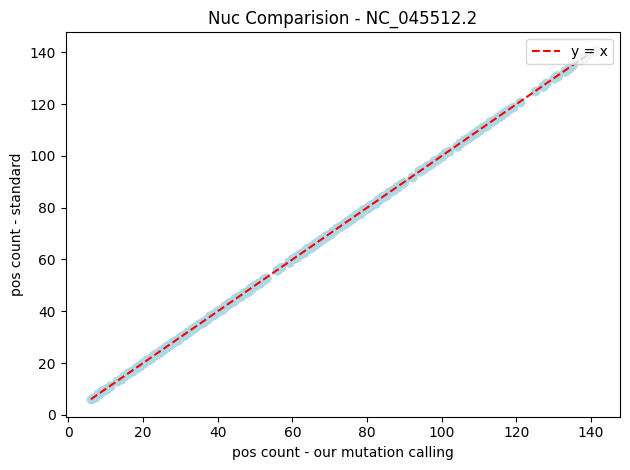

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


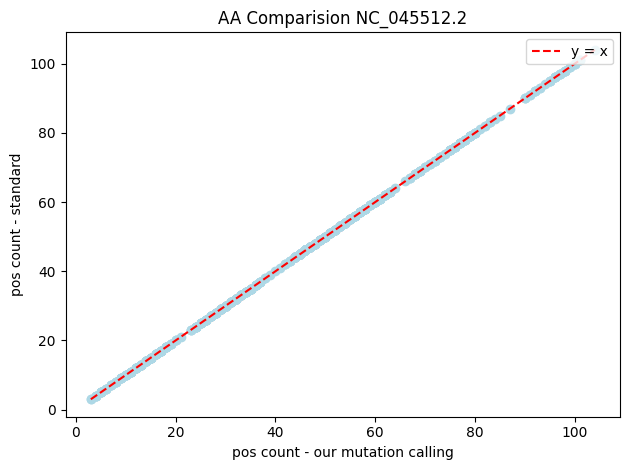

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []
68031
68031


In [10]:
tmp1, tmp2 = compare(hu1_gf_dir, sc2_mm_dir, "NC_045512.2")

NC_045512.2_escape_BA.1_rbd
997
647009
100.0 % identical in alignment.


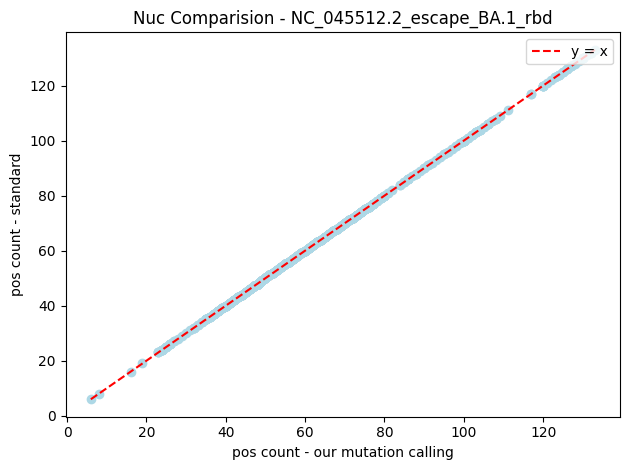

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


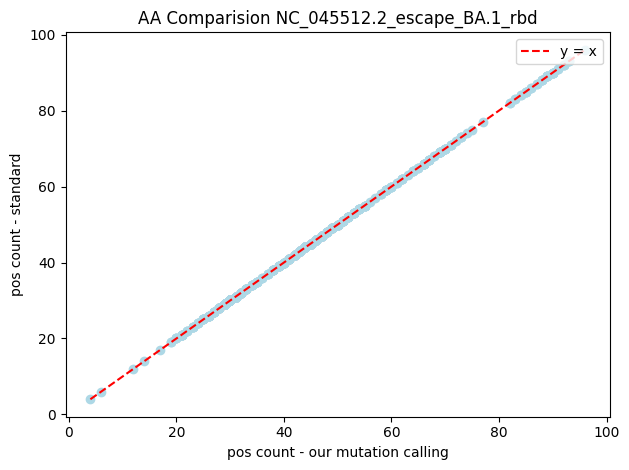

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []
67910
67910


In [ ]:
tmp1, tmp2 = compare(ba1_gf_dir, sc2_mm_dir, "NC_045512.2_escape_BA.1_rbd")

NC_045512.2_escape_BA.2_rbd
997
646447
100.0 % identical in alignment.


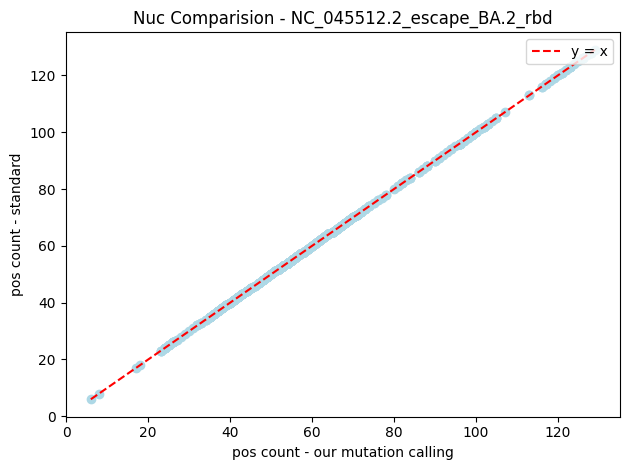

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


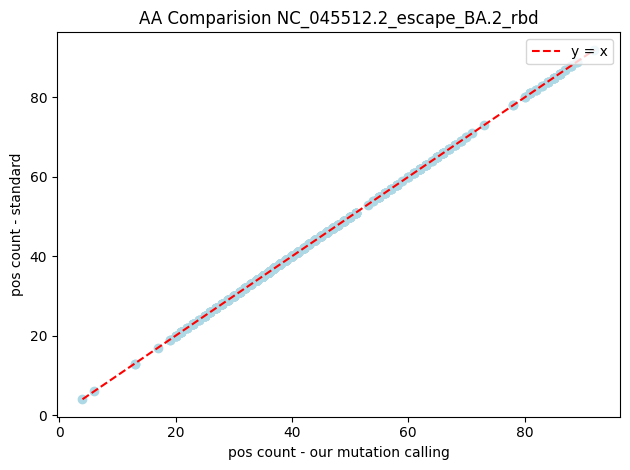

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []
67348
67348


In [ ]:
tmp1, tmp2 = compare(ba2_gf_dir, sc2_mm_dir, "NC_045512.2_escape_BA.2_rbd")

NC_045512.2_escape_BA.2.75_rbd
997
647814
100.0 % identical in alignment.


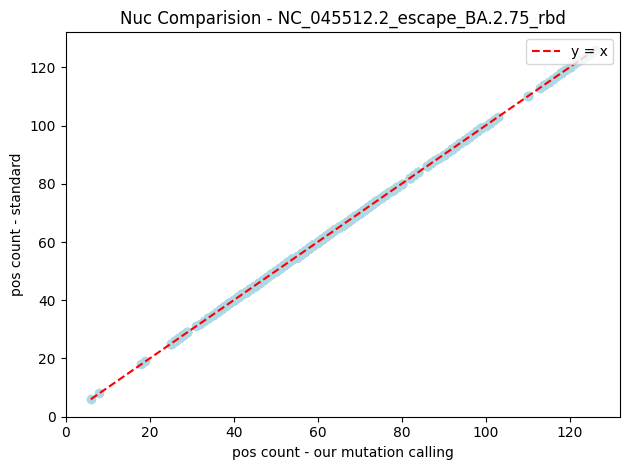

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


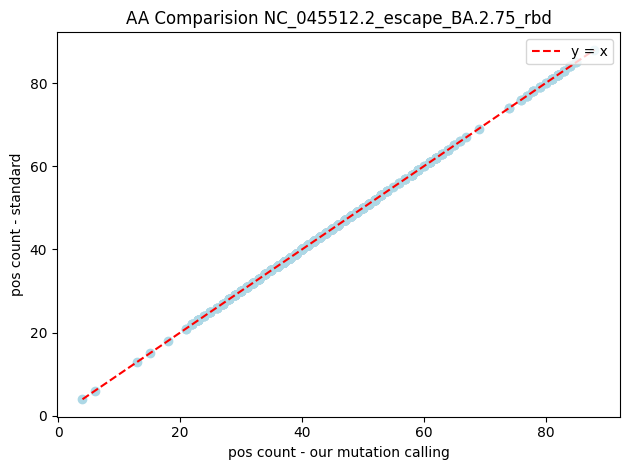

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []
68715
68715


In [14]:
tmp1, tmp2 = compare(ba275_gf_dir, sc2_mm_dir, "NC_045512.2_escape_BA.2.75_rbd")

NC_045512.2_escape_BA.4-BA.5_rbd
997
646554
100.0 % identical in alignment.


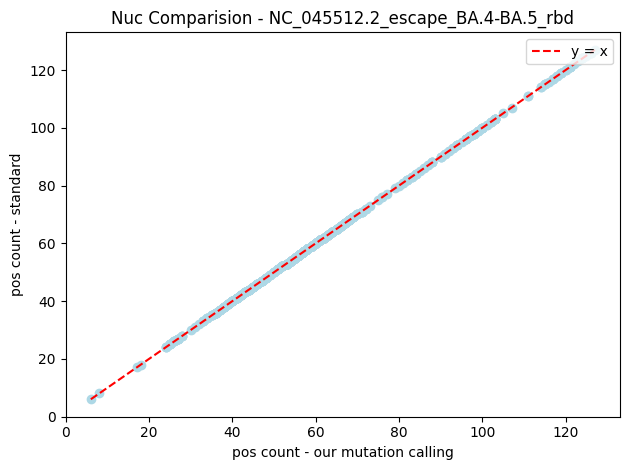

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


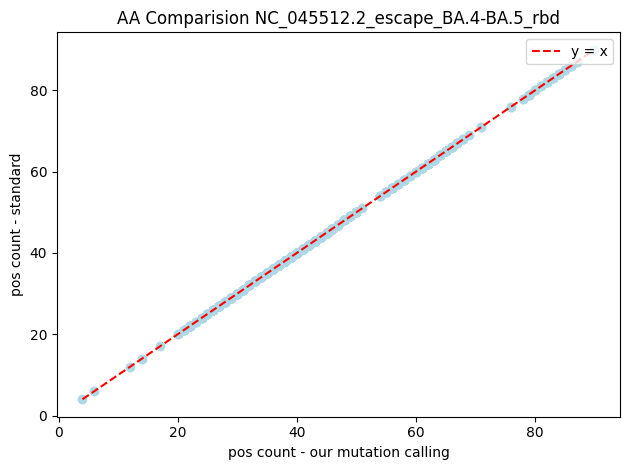

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []
67455
67455


In [16]:
tmp1, tmp2 = compare(ba45_gf_dir, sc2_mm_dir, "NC_045512.2_escape_BA.4-BA.5_rbd")

NC_045512.2_escape_XBB.1.5_rbd
996
652850
100.0 % identical in alignment.


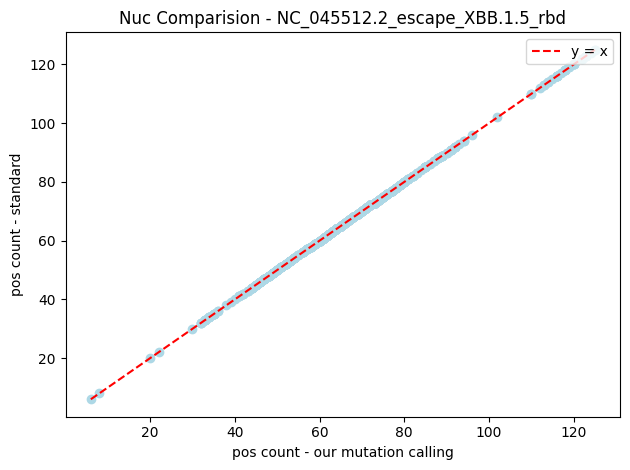

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


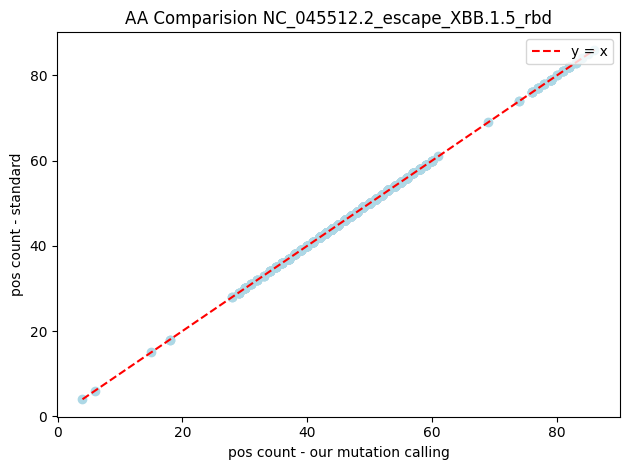

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []
73762
73762


In [ ]:
tmp1, tmp2 = compare(xbb_gf_dir, sc2_mm_dir, "NC_045512.2_escape_XBB.1.5_rbd")

NC_045512.2_escape_JN.1_rbd
957
635553
94.0 % identical in alignment.


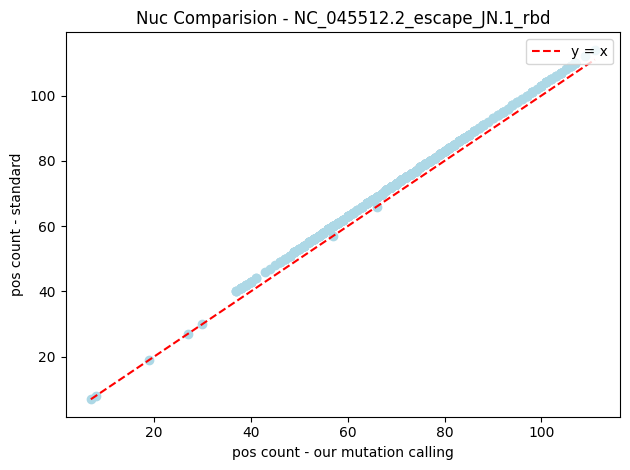

/tmp/ipykernel_3353625/4068971782.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]


                    sra  pos_count_standard  pos_count_manual  gap
956       STM-ZMR4VFTFK                  82                79   -3
0             ALSR-1584                  41                38   -3
1             ALSR-1678                  40                37   -3
2         ATM-H48RA4QQ6                  76                73   -3
3         ATM-Q4EEY2D3N                  68                65   -3
..                  ...                 ...               ...  ...
25   CA-SDCPHL-82421030                  70                67   -3
26   CA-SDCPHL-91021350                  66                63   -3
27     CA-SEARCH-103136                  70                67   -3
28     CA-SEARCH-103152                  56                53   -3
29     CA-SEARCH-103471                  53                50   -3

[950 rows x 4 columns]


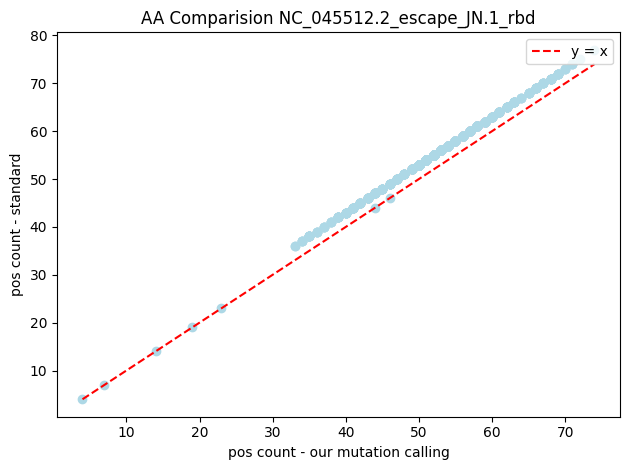

                    sra  pos_count_standard  pos_count_manual  gap
956       STM-ZMR4VFTFK                  55                52   -3
0             ALSR-1584                  37                34   -3
1             ALSR-1678                  38                35   -3
2         ATM-H48RA4QQ6                  60                57   -3
3         ATM-Q4EEY2D3N                  56                53   -3
..                  ...                 ...               ...  ...
25   CA-SDCPHL-82421030                  56                53   -3
26   CA-SDCPHL-91021350                  55                52   -3
27     CA-SEARCH-103136                  57                54   -3
28     CA-SEARCH-103152                  46                43   -3
29     CA-SEARCH-103471                  45                42   -3

[950 rows x 4 columns]
77101
74251


/tmp/ipykernel_3353625/5948700.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]


ValueError: Can only compare identically-labeled (both index and columns) DataFrame objects

In [24]:
tmp1, tmp2 = compare(jn1_gf_dir, sc2_mm_dir, "NC_045512.2_escape_JN.1_rbd")

NC_045512.2_escape_KP.2_rbd
957
637883
94.0 % identical in alignment.


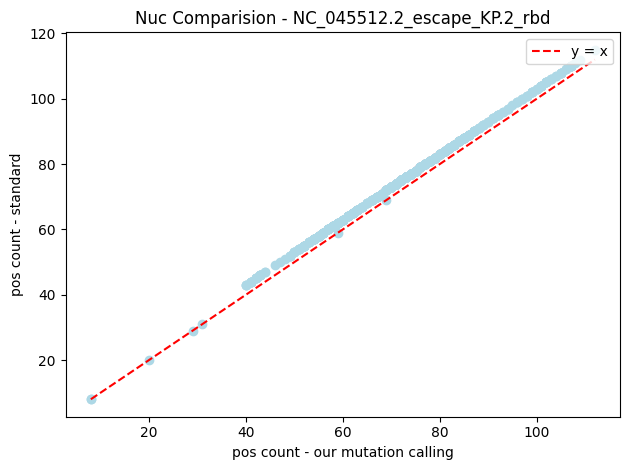

/tmp/ipykernel_3353625/4068971782.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]


                    sra  pos_count_standard  pos_count_manual  gap
956       STM-ZMR4VFTFK                  85                82   -3
0             ALSR-1584                  44                41   -3
1             ALSR-1678                  43                40   -3
2         ATM-H48RA4QQ6                  79                76   -3
3         ATM-Q4EEY2D3N                  71                68   -3
..                  ...                 ...               ...  ...
25   CA-SDCPHL-82421030                  73                70   -3
26   CA-SDCPHL-91021350                  69                66   -3
27     CA-SEARCH-103136                  73                70   -3
28     CA-SEARCH-103152                  59                56   -3
29     CA-SEARCH-103471                  56                53   -3

[950 rows x 4 columns]


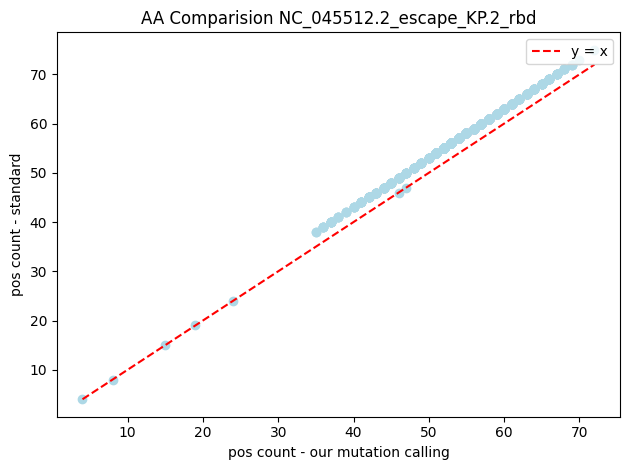

                    sra  pos_count_standard  pos_count_manual  gap
956       STM-ZMR4VFTFK                  57                54   -3
0             ALSR-1584                  39                36   -3
1             ALSR-1678                  40                37   -3
2         ATM-H48RA4QQ6                  62                59   -3
3         ATM-Q4EEY2D3N                  58                55   -3
..                  ...                 ...               ...  ...
25   CA-SDCPHL-82421030                  58                55   -3
26   CA-SDCPHL-91021350                  57                54   -3
27     CA-SEARCH-103136                  59                56   -3
28     CA-SEARCH-103152                  48                45   -3
29     CA-SEARCH-103471                  47                44   -3

[950 rows x 4 columns]
79431
76581


/tmp/ipykernel_3353625/5948700.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]


ValueError: Can only compare identically-labeled (both index and columns) DataFrame objects

In [25]:
tmp1, tmp2 = compare(kp2_gf_dir, sc2_mm_dir, "NC_045512.2_escape_KP.2_rbd")

NC_045512.2_escape_KP.3_rbd
957
638281
94.0 % identical in alignment.


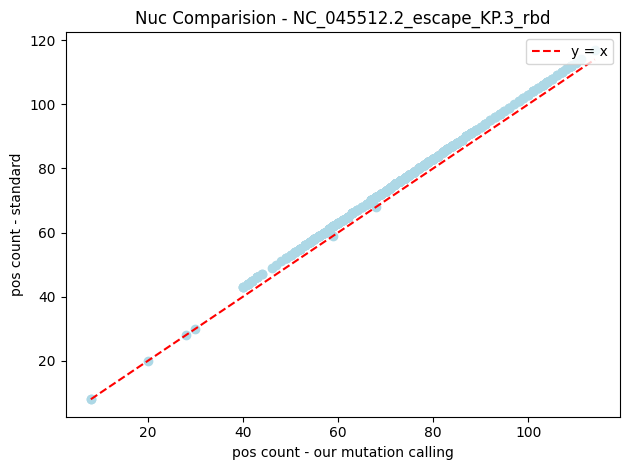

                    sra  pos_count_standard  pos_count_manual  gap
956       STM-ZMR4VFTFK                  85                82   -3
0             ALSR-1584                  44                41   -3
1             ALSR-1678                  43                40   -3
2         ATM-H48RA4QQ6                  79                76   -3
3         ATM-Q4EEY2D3N                  71                68   -3
..                  ...                 ...               ...  ...
25   CA-SDCPHL-82421030                  73                70   -3
26   CA-SDCPHL-91021350                  69                66   -3
27     CA-SEARCH-103136                  73                70   -3
28     CA-SEARCH-103152                  59                56   -3
29     CA-SEARCH-103471                  56                53   -3

[950 rows x 4 columns]

/tmp/ipykernel_3353625/4068971782.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]


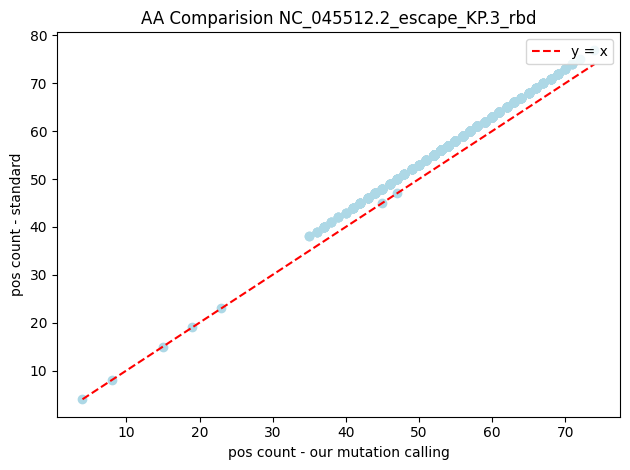

                    sra  pos_count_standard  pos_count_manual  gap
956       STM-ZMR4VFTFK                  57                54   -3
0             ALSR-1584                  39                36   -3
1             ALSR-1678                  40                37   -3
2         ATM-H48RA4QQ6                  62                59   -3
3         ATM-Q4EEY2D3N                  58                55   -3
..                  ...                 ...               ...  ...
25   CA-SDCPHL-82421030                  58                55   -3
26   CA-SDCPHL-91021350                  57                54   -3
27     CA-SEARCH-103136                  59                56   -3
28     CA-SEARCH-103152                  48                45   -3
29     CA-SEARCH-103471                  47                44   -3

[950 rows x 4 columns]
79829
76979


/tmp/ipykernel_3353625/5948700.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]


ValueError: Can only compare identically-labeled (both index and columns) DataFrame objects

In [26]:
tmp1, tmp2 = compare(kp3_gf_dir, sc2_mm_dir, "NC_045512.2_escape_KP.3_rbd")